# Get the data

In [36]:
import pandas as pd
train_set=pd.read_csv('anotherdataset/train.csv')
test_set=pd.read_csv('anotherdataset/test.csv')

In [37]:
#快速查看数据结构
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 探索性数据分析

In [38]:
import matplotlib.pyplot as plt
train_set.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

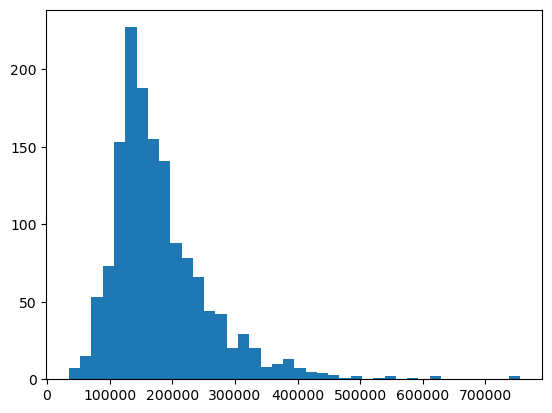

In [39]:
#价格分布
SalePrice=train_set['SalePrice'].values
plt.hist(SalePrice, bins=40)
plt.show()

In [40]:
#查看训练数据属性
train_set.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

In [41]:
#把训练集分成数值类型和类别类型
train_set_cat = train_set.select_dtypes(include='object')
train_set_cat['SalePrice'] = train_set['SalePrice']
train_set_num = train_set.select_dtypes(include='number')
train_set_num['SalePrice'] = train_set['SalePrice']

In [42]:
#方差分析
from scipy.stats import f_oneway
def ANOVA(df, feature):
    category_groups = df.groupby(feature)['SalePrice'].apply(list)
    return f_oneway(*category_groups)

In [43]:
p_vals = {}
for col in train_set_cat.columns:
    p_vals[col] = ANOVA(train_set_cat, col).statistic
p_vals.pop('SalePrice')

d:\Anaconda\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


inf

In [44]:
#最先查看前十个影响因子，后面选取不同的数量比较了一下训练效果，最后选取了30个
cat_features=sorted(p_vals, key=p_vals.get, reverse=True)

In [45]:
#皮尔逊相关系数
corr = train_set_num.corr(method='pearson')
corr = corr.SalePrice.apply(abs).to_dict()
corr.pop('SalePrice')
num_fetures=sorted(corr, key=corr.get, reverse=True)

In [46]:
features = cat_features+num_fetures
train_set[features].head(5)

,ExterQual,KitchenQual,BsmtQual,GarageFinish,Foundation,CentralAir,HeatingQC,Neighborhood,GarageType,BsmtExposure,...,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
0,Gd,Gd,Gd,RFn,PConc,Y,Ex,CollgCr,Attchd,No,...,60,5,2,0,2008,0,1,0,0,0
1,TA,TA,Gd,RFn,CBlock,Y,Ex,Veenker,Attchd,Gd,...,20,8,5,0,2007,0,2,0,1,0
2,Gd,Gd,Gd,RFn,PConc,Y,Ex,CollgCr,Attchd,Mn,...,60,5,9,0,2008,0,3,0,0,0
3,TA,Gd,TA,Unf,BrkTil,Y,Gd,Crawfor,Detchd,No,...,70,5,2,0,2006,0,4,0,0,0
4,Gd,Gd,Gd,RFn,PConc,Y,Ex,NoRidge,Attchd,Av,...,60,5,12,0,2008,0,5,0,0,0


# 数据预处理

In [47]:
from sklearn.model_selection import  train_test_split
X = train_set[features].loc[:, train_set[features].columns != "SalePrice"]
y = train_set['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
#标准化数据
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalizedVars = scaler.fit_transform(X_train[num_fetures])
normalizedVars_df = pd.DataFrame(normalizedVars, columns=scaler.get_feature_names_out())
normalizedVars_df=normalizedVars_df.fillna(0)
normalizedVars_df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
0,0.637073,-0.051643,0.293831,-0.192617,0.642893,0.862092,0.772872,0.268177,1.107889,1.020374,...,1.475911,-0.515364,-0.508139,-0.121808,0.137143,-0.119821,0.698315,-0.123489,-0.243017,-0.284678
1,-0.094926,-0.421692,0.293831,0.030695,-0.046799,0.357895,-1.062909,-0.963076,0.094543,0.682585,...,-0.871228,0.390453,-2.000860,-0.121808,-1.372124,-0.119821,0.196372,-0.123489,-0.243017,2.166141
2,-0.094926,-0.518474,-1.069494,-0.938576,-1.128667,-1.221922,-1.062909,-0.347450,-1.049557,-1.681937,...,-0.167086,-0.515364,1.357763,-0.121808,0.891777,-0.119821,1.549025,-0.123489,-0.243017,-0.284678
3,-0.826925,-0.207253,-1.069494,-0.910068,-0.186540,0.650071,-1.062909,-0.347450,-0.363097,-0.330782,...,-0.871228,-0.515364,0.611402,-0.121808,-0.617490,-0.119821,-0.237231,1.704639,-0.243017,-0.284678
4,-0.094926,-0.169300,-1.069494,-0.838798,0.859266,0.701784,-1.062909,0.268177,-0.428474,-1.295893,...,-0.871228,0.390453,-0.881319,-0.121808,-0.617490,-0.119821,0.203441,1.399951,-0.243017,-0.284678


In [49]:
#独热编码
from sklearn.preprocessing import OneHotEncoder 
enc = OneHotEncoder(handle_unknown='ignore')
categoricalVars = enc.fit_transform(X_train[cat_features]).toarray()
categoricalVars_df = pd.DataFrame(categoricalVars, columns=enc.get_feature_names_out())
categoricalVars_df=categoricalVars_df.fillna(0.0)  #在这里用0.0填充了缺失值
categoricalVars_df.head()


,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,Condition2_RRAn,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Utilities_AllPub,Utilities_NoSeWa
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [50]:
#合并数据
X_train_cleaned = pd.concat([categoricalVars_df, normalizedVars_df], axis='columns')
X_train_cleaned.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.475911,-0.515364,-0.508139,-0.121808,0.137143,-0.119821,0.698315,-0.123489,-0.243017,-0.284678
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.871228,0.390453,-2.000860,-0.121808,-1.372124,-0.119821,0.196372,-0.123489,-0.243017,2.166141
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.167086,-0.515364,1.357763,-0.121808,0.891777,-0.119821,1.549025,-0.123489,-0.243017,-0.284678
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.871228,-0.515364,0.611402,-0.121808,-0.617490,-0.119821,-0.237231,1.704639,-0.243017,-0.284678
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.871228,0.390453,-0.881319,-0.121808,-0.617490,-0.119821,0.203441,1.399951,-0.243017,-0.284678


In [51]:
#按一样的步骤操作测试集
X_test_categorical = enc.transform(X_test[cat_features]).toarray()
X_test_categorical_df = pd.DataFrame(X_test_categorical, columns = enc.get_feature_names_out())
X_test_categorical_df=X_test_categorical_df.fillna(0)
X_test_normalized = scaler.transform(X_test[num_fetures])
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=scaler.get_feature_names_out())
X_test_normalized_df=X_test_normalized_df.fillna(0.0)
X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
X_test_cleaned.head()

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.871228,2.202087,-1.627680,-0.121808,-1.372124,-0.119821,0.389608,-0.123489,3.980849,-0.284678
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.067628,-0.515364,-0.881319,-0.121808,1.646410,-0.119821,0.891551,-0.123489,-0.243017,-0.284678
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.636514,0.390453,-1.254499,-0.121808,1.646410,-0.119821,-0.739174,-0.123489,-0.243017,-0.284678
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.167086,1.296270,1.357763,-0.121808,-1.372124,-0.119821,-0.482311,-0.123489,-0.243017,-0.284678
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.871228,-0.515364,0.984583,-0.121808,0.891777,-0.119821,0.728950,-0.123489,-0.243017,-0.284678


# 模型训练

In [52]:
#使用线性回归但是效果并不好
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_cleaned, y_train)
y_pred_train = lin_reg.predict(X_train_cleaned)
y_pred_test = lin_reg.predict(X_test_cleaned)
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))


Train RMSE: 19365.657416342034
Test RMSE: 1.356963092495068e+16


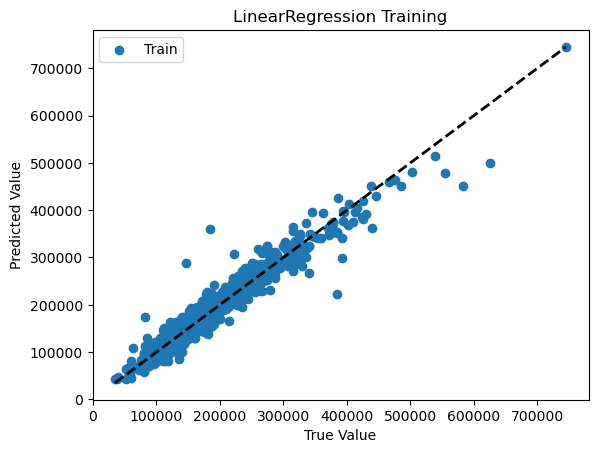

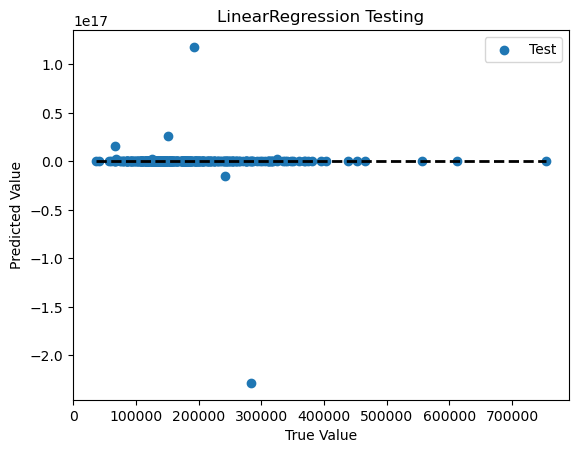

In [53]:
#训练结果可视化
# 绘制训练集的预测值与真实值关系  
plt.scatter(y_train, y_pred_train, label='Train')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('LinearRegression Training')  
plt.legend()  
plt.show()  
  
# 绘制测试集的预测值与真实值关系  
plt.scatter(y_test, y_pred_test, label='Test')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('LinearRegression Testing')  
plt.legend()  
plt.show()

In [54]:
#选用SGDRegressor效果好了很多
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
sgd = SGDRegressor(loss="squared_error", fit_intercept=True, learning_rate='invscaling', eta0=0.01)  
train_rmse_list=[]
test_rmse_list=[]
best_train_rmse = np.inf  # 初始化最佳RMSE为无穷大 
best_test_rmse=np.inf 
best_model = None  # 初始化最佳模型为None 
for epoch in range(100):  # 假设我们训练100个epoch  
    sgd.fit(X_train_cleaned, y_train)
    y_pred_train = sgd.predict(X_train_cleaned)
    y_pred_test = sgd.predict(X_test_cleaned)
    train_rmse=mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse=mean_squared_error(y_test, y_pred_test, squared=False)
    train_rmse_list.append(train_rmse)  
    test_rmse_list.append(test_rmse) 
     # 检查当前轮次的RMSE是否小于之前最好的RMSE  
    if train_rmse < best_train_rmse:  
        best_train_rmse = train_rmse 
        best_model = sgd  # 更新最佳模型  
    if test_rmse < best_test_rmse:  
        best_test_rmse = train_rmse 
# 输出最佳RMSE和最佳模型  
print("Best train RMSE:", best_train_rmse)  
print("Best test RMSE:", best_test_rmse)  

#由此指标可以看出模型具有较好的泛化能力

Best train RMSE: 24824.10035146503
Best test RMSE: 27047.999493843272


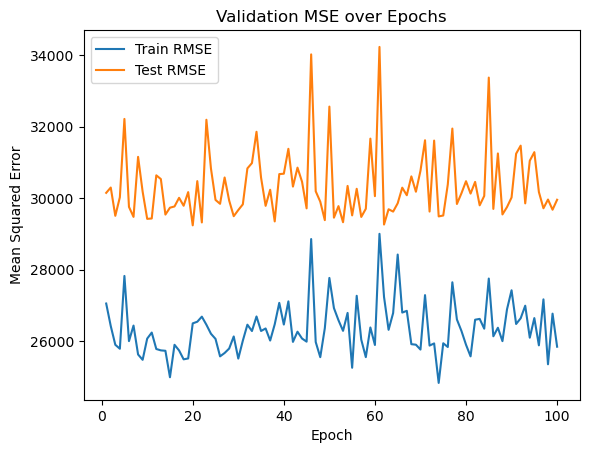

In [55]:
#训练过程可视化
# 初始化图形  
fig, ax = plt.subplots()  
# 在同一张图上绘制训练集和测试集的RMSE  
ax.plot(range(1, 101), train_rmse_list, label='Train RMSE')  
ax.plot(range(1, 101), test_rmse_list, label='Test RMSE')    
# 设置图形的标题和X、Y轴标签  
ax.set_title('Validation MSE over Epochs')  
ax.set_xlabel('Epoch')  
ax.set_ylabel('Mean Squared Error')  
# 显示图例  
ax.legend()  
# 显示图形  
plt.show()



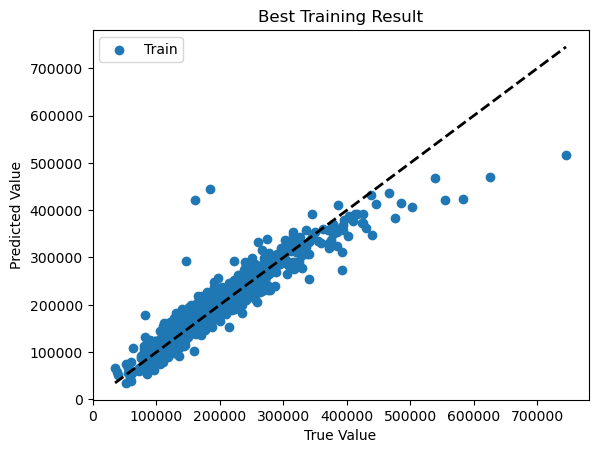

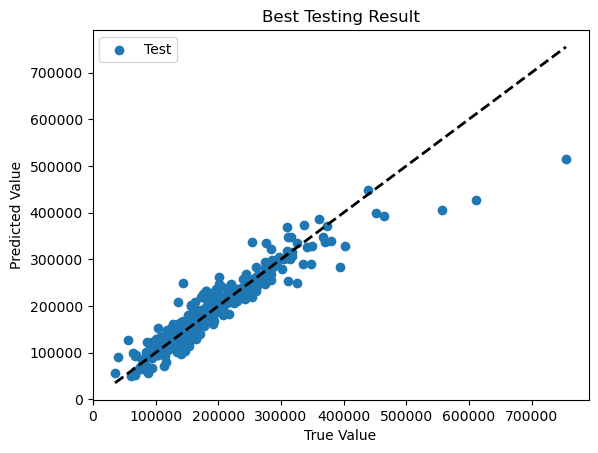

In [56]:
#最佳训练结果可视化
y_pred_train = sgd.predict(X_train_cleaned)
y_pred_test = sgd.predict(X_test_cleaned)
# 绘制训练集的预测值与真实值关系  
plt.scatter(y_train, y_pred_train, label='Train')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('Best Training Result')  
plt.legend()  
plt.show()  
  
# 绘制测试集的预测值与真实值关系  
plt.scatter(y_test, y_pred_test, label='Test')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  
plt.xlabel('True Value')  
plt.ylabel('Predicted Value')  
plt.title('Best Testing Result')  
plt.legend()  
plt.show()

# 研究选取不同的训练集对训练结果的影响


In [57]:
# 经过对43个类别型和38个数值型数据组合的训练结果的考察，我猜想训练结果和两者的组合方式存在一定联系。我想要通过枚举法找到使训练结果最佳的组合方式。但是最后并没有成功

# from mpl_toolkits.mplot3d import Axes3D  
# import matplotlib.pyplot as plt 
# import numpy as np
# min_train_rmse = float('inf')
# best_x, best_y = None, None
# Z=[]
# for x in range(1,39):
#   normalizedVars_df= normalizedVars_df.iloc[:, :x]
#   X_test_normalized_df=X_test_normalized_df.iloc[:,:x]
#   for y in range(1,44):
#       categoricalVars_df=categoricalVars_df.iloc[:, :y] 
#       X_test_categorical_df=X_test_categorical_df.iloc[:, :y] 
#       X_train_cleaned = pd.concat([categoricalVars_df, normalizedVars_df], axis='columns')
#       X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
#       y_pred_train = sgd.predict(X_train_cleaned)
#       y_pred_test = sgd.predict(X_test_cleaned)
#       TestRMSE=mean_squared_error(y_test, y_pred_test, squared=False)
#       trainRMSE=mean_squared_error(y_train,y_pred_train)
#       Z.append(trainRMSE)
#        # Check if the current TestRMSE is smaller than the minimum recorded TestRMSE
#       if trainRMSE < min_test_rmse:
#             min_test_rmse = TestRMSE
#             best_x, best_y = x, y




In [58]:
# 使用决策树模型
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error  
  
tree_reg = DecisionTreeRegressor(random_state=42)  
tree_reg.fit(X_train_cleaned, y_train)  
y_pred_train = tree_reg.predict(X_train_cleaned)  
y_pred_test = tree_reg.predict(X_test_cleaned)  
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))  
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE: 0.0
Test RMSE: 37314.25272304742


In [59]:
#使用随机森林
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error  
  
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_reg.fit(X_train_cleaned, y_train)  
y_pred_train = rf_reg.predict(X_train_cleaned)  
y_pred_test = rf_reg.predict(X_test_cleaned)  
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))  
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE: 11930.323119627226
Test RMSE: 27551.82755789512


# 结果
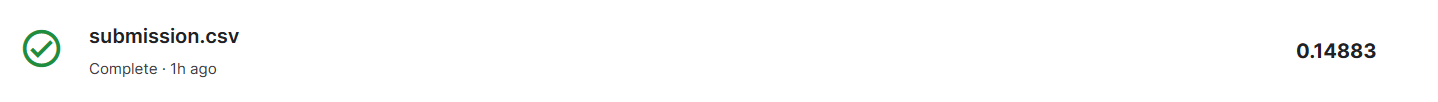

In [60]:
#使用Adaboost方法 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor  
from sklearn.metrics import mean_squared_error  
  
# 定义随机森林回归器作为弱学习器  
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)   
# 定义AdaBoost集成回归器  
ada_reg = AdaBoostRegressor(estimator=rf_reg, n_estimators=50, random_state=42)   
# 训练AdaBoost集成回归器  
ada_reg.fit(X_train_cleaned, y_train)    
# 使用训练好的模型进行预测  
y_pred_train = ada_reg.predict(X_train_cleaned)  
y_pred_test = ada_reg.predict(X_test_cleaned)    
# 输出训练集和测试集的均方根误差（RMSE）  
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))  
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE: 5394.076862475168
Test RMSE: 25298.019430877765


# 结果
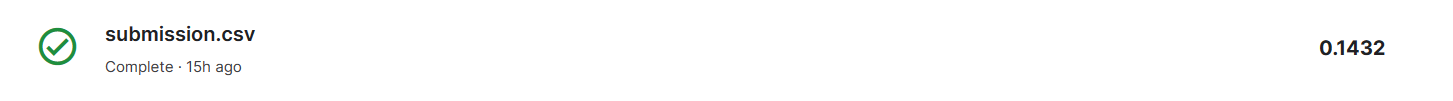

In [61]:
#使用xgboost  
from sklearn.metrics import mean_squared_error  
from xgboost import XGBRegressor  # 添加这一行以使用XGBoost  
xgb_reg = XGBRegressor(estimator=ada_reg,n_estimators=200, random_state=42)    
xgb_reg.fit(X_train_cleaned, y_train)  
# 使用训练好的模型进行预测  
y_pred_train = xgb_reg.predict(X_train_cleaned)  
y_pred_test = xgb_reg.predict(X_test_cleaned)  
# 输出训练集和测试集的均方根误差（RMSE）  
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))  
print('Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))

d:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Train RMSE: 110.65085609374567
Test RMSE: 26099.858213007665


# 结果
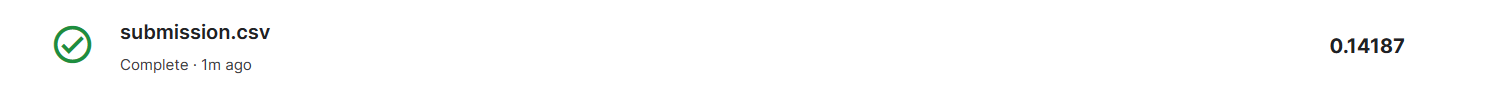

In [62]:
#使用baggingregressor对上面的基础模型进行集成学习
from sklearn.ensemble import BaggingRegressor
# 使用Bagging对上面的基础模型进行集成学习  
bagging_model = BaggingRegressor(estimator=xgb_reg, n_estimators=10, random_state=42)    
bagging_model.fit(X_train_cleaned, y_train)   
y_pred_train = bagging_model.predict(X_train_cleaned)  
y_pred_test = bagging_model.predict(X_test_cleaned)  
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))   
print('test RMSE:', mean_squared_error(y_test, y_pred_test,squared=False))


d:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:02] WARNING: C:\buildkite-agent\bui

Train RMSE: 11933.226552399618
test RMSE: 25758.50027146125


# 结果
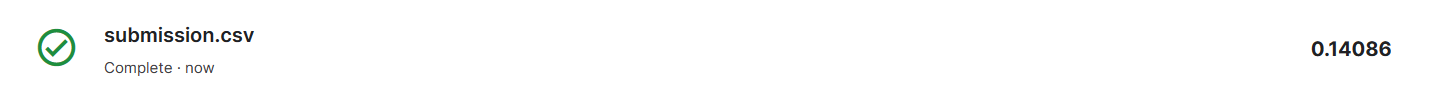

# 预测房价

In [63]:
test_features = [feature for feature in features if feature != 'SalePrice']
X_test_df = test_set[test_features]
X_test_categorical = enc.transform(X_test_df[cat_features]).toarray()
X_test_categorical_df = pd.DataFrame(X_test_categorical, columns = enc.get_feature_names_out())
X_test_normalized = scaler.transform(X_test_df[num_fetures])
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=scaler.get_feature_names_out())
X_test_cleaned = pd.concat([X_test_categorical_df, X_test_normalized_df], axis='columns')
X_test_cleaned

,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtQual_Ex,BsmtQual_Fa,...,MSSubClass,OverallCond,MoSold,3SsnPorch,YrSold,LowQualFinSF,Id,MiscVal,BsmtHalfBath,BsmtFinSF2
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.871228,0.390453,-0.134958,-0.121808,1.646410,-0.119821,1.728122,-0.123489,-0.243017,0.651444
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.871228,0.390453,-0.134958,-0.121808,1.646410,-0.119821,1.730479,37.962510,-0.243017,-0.284678
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.067628,-0.515364,-1.254499,-0.121808,1.646410,-0.119821,1.732835,-0.123489,-0.243017,-0.284678
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.067628,0.390453,-0.134958,-0.121808,1.646410,-0.119821,1.735192,-0.123489,-0.243017,-0.284678
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.475911,-0.515364,-2.000860,-0.121808,1.646410,-0.119821,1.737548,-0.123489,-0.243017,-0.284678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.414766,1.296270,-0.134958,-0.121808,-1.372124,-0.119821,5.154529,-0.123489,-0.243017,-0.284678
1455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.414766,-0.515364,-0.881319,-0.121808,-1.372124,-0.119821,5.156886,-0.123489,-0.243017,-0.284678
1456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.871228,1.296270,0.984583,-0.121808,-1.372124,-0.119821,5.159243,-0.123489,-0.243017,-0.284678
1457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.654412,-0.515364,0.238222,-0.121808,-1.372124,-0.119821,5.161599,2.009327,3.980849,-0.284678


In [64]:
#处理缺失值
X_test_cleaned.isnull().sum().sum()
X_test_cleaned[X_test_cleaned['TotalBsmtSF'].isnull()]
X_test_cleaned[X_test_cleaned['GarageArea'].isnull()]
X_test_cleaned[X_test_cleaned['GarageCars'].isnull()]
X_test_cleaned = X_test_cleaned.fillna(0)

In [71]:
y_pred = bagging_model.predict(X_test_cleaned)

In [72]:
final_df = pd.DataFrame()
final_df['Id'] = test_set['Id'].values
final_df['SalePrice'] = y_pred
final_df.head(5)

,Id,SalePrice
0,1461,129095.937500
1,1462,155876.812500
2,1463,185921.265625
3,1464,187606.218750
4,1465,210234.031250


In [73]:
#写入提交文件
final_df.to_csv('anotherdataset/submission.csv', index=False)


# 最佳结果
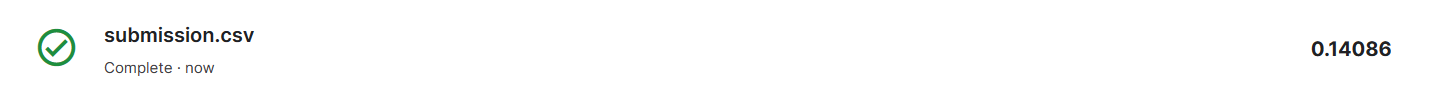